Accuracy: 100.0% | F1 Score: 1.0


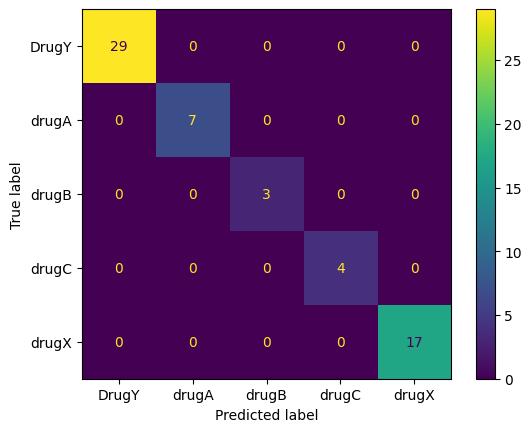

In [9]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from skops.io import dump, load, get_untrusted_types

# Load dataset and shuffle
drug_df = pd.read_csv("Data/drug.csv").sample(frac=1, random_state=125)

# Split data
X = drug_df.drop("Drug", axis=1)
y = drug_df["Drug"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=125)

# Define categorical and numerical columns
cat_col = [1, 2, 3]  
num_col = [0, 4]  

# Define transformations
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
])

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

transform = ColumnTransformer([
    ("cat", cat_pipeline, cat_col),
    ("num", num_pipeline, num_col)
])

# Define the model pipeline
pipe = Pipeline([
    ("preprocessing", transform),
    ("model", RandomForestClassifier(n_estimators=100, random_state=125, min_samples_leaf=2, max_features='sqrt'))
], memory="cache_directory")

# Train the model
pipe.fit(X_train, y_train)

# Predictions & Metrics
predictions = pipe.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average="macro")

print(f"Accuracy: {round(accuracy * 100, 2)}% | F1 Score: {round(f1, 2)}")

# Ensure directories exist
os.makedirs("Results", exist_ok=True)
os.makedirs("Model", exist_ok=True)

# Save metrics
with open("Results/metrics.txt", "w") as outfile:
    outfile.write(f"Accuracy = {accuracy:.2f}, F1 Score = {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.savefig("Results/model_results.png", dpi=120)

In [10]:
# Save and Load Model
dump(pipe, "Model/drug_pipeline.skops")
unknown_types = get_untrusted_types(file="Model/drug_pipeline.skops")
print(unknown_types)
loaded_pipe = load("Model/drug_pipeline.skops", trusted=unknown_types)
print(loaded_pipe.score(X_test, y_test))

['numpy.dtype']
1.0


In [11]:
# in memory
from skops.io import dumps, loads
serialized = dumps(pipe)
loaded = loads(serialized, trusted=unknown_types)